In [ ]:
import os
import random
import shutil
from pathlib import Path

def split_dataset(images_dir, labels_dir, output_dir, train_ratio=0.8):

    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif'}
    

    all_images = [f for f in os.listdir(images_dir) if Path(f).suffix.lower() in image_extensions]
    total_count = len(all_images)
    

    random.shuffle(all_images)
    
    train_count = int(total_count * train_ratio)
    train_images = all_images[:train_count]
    val_images = all_images[train_count:]

    for split in ['train', 'val']:
        os.makedirs(os.path.join(output_dir, 'images', split), exist_ok=True)
        os.makedirs(os.path.join(output_dir, 'labels', split), exist_ok=True)
    

    def copy_files(file_list, split):
        for filename in file_list:
   
            shutil.copy2(os.path.join(images_dir, filename),
                         os.path.join(output_dir, 'images', split, filename))
            
           
            label_name = Path(filename).with_suffix('.txt').name
            label_src = os.path.join(labels_dir, label_name)
            label_dst = os.path.join(output_dir, 'labels', split, label_name)
            if os.path.exists(label_src):
                shutil.copy2(label_src, label_dst)
            else:
                print(f"Внимание: для {filename} не найден файл разметки {label_name}")

    copy_files(train_images, 'train')
    copy_files(val_images, 'val')
    
    print(f"Всего изображений: {total_count}")
    print(f"Обучающая выборка: {len(train_images)}")
    print(f"Валидационная выборка: {len(val_images)}")

if __name__ == "__main__":
    images_folder = "/home/dmitriy/PycharmProjects/T-bank/data/images"
    labels_folder = "/home/dmitriy/PycharmProjects/T-bank/data/labels"
    output_folder = "/home/dmitriy/PycharmProjects/T-bank/data_train_val"
    
    split_dataset(images_folder, labels_folder, output_folder, train_ratio=0.8)


Всего изображений: 353
Обучающая выборка: 282
Валидационная выборка: 71


In [ ]:
from ultralytics import YOLO
import yaml
import os


with open('/home/dmitriy/PycharmProjects/T-bank/classes.txt', 'r', encoding='utf-8') as f:
    class_names = [line.strip() for line in f if line.strip()]
names_dict = {i: name for i, name in enumerate(class_names)}

data_config = {
    'path': os.path.abspath('.'),
    'train': '/home/dmitriy/PycharmProjects/T-bank/data_train_val/images/train',
    'val': '/home/dmitriy/PycharmProjects/T-bank/data_train_val/images/val',
    'names': names_dict
}
with open('data.yaml', 'w', encoding='utf-8') as f:
    yaml.dump(data_config, f, allow_unicode=True)

print('data.yaml создан.')


model = YOLO('yolov8s.pt') 
model.train(
    data='data.yaml',
    epochs=50,
    batch=6,
    imgsz=640,
    name='logo_yolov8',
    exist_ok=True
)
print("Обучение закончено.")


data.yaml создан.
New https://pypi.org/project/ultralytics/8.3.193 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.192 🚀 Python-3.11.8 torch-2.8.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 7817MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=6, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=logo_yolov8, nbs=64, nms=False

In [2]:
from ultralytics import YOLO

model = YOLO('runs/detect/logo_yolov8/weights/best.pt')




results = model.predict(source='/home/dmitriy/vs_code/T-bank/image copy.png', imgsz=640)


results[0].show()




image 1/1 /home/dmitriy/vs_code/T-bank/image copy.png: 416x640 (no detections), 30.5ms
Speed: 0.9ms preprocess, 30.5ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 640)


pci id for fd 53: 10de:28a0, driver (null)
pci id for fd 54: 10de:28a0, driver (null)


In [1]:
import os
import random
import shutil
from pathlib import Path
from ultralytics import YOLO

def auto_annotate(model_path, new_images_dir, labels_output_dir, conf_threshold=0.3, imgsz=640):
    os.makedirs(labels_output_dir, exist_ok=True)
    model = YOLO(model_path)
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif'}

    for image_file in os.listdir(new_images_dir):
        if Path(image_file).suffix.lower() in image_extensions:
            image_path = os.path.join(new_images_dir, image_file)
            results = model.predict(source=image_path, imgsz=imgsz, conf=conf_threshold)
            result = results[0]

            if result.boxes is not None and len(result.boxes) > 0:
                label_path = os.path.join(labels_output_dir, Path(image_file).stem + '.txt')
                with open(label_path, 'w') as f:
                    for box in result.boxes.data.cpu().numpy():
                        x1, y1, x2, y2, score, cls = box
                        width = x2 - x1
                        height = y2 - y1
                        x_center = x1 + width / 2
                        y_center = y1 + height / 2
                        img_width, img_height = result.orig_img.shape[1], result.orig_img.shape[0]
                        x_center /= img_width
                        y_center /= img_height
                        width /= img_width
                        height /= img_height
                        f.write(f"{int(cls)} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")
                print(f"Разметка сохранена для {image_file} в {label_path}")
            else:
                print(f"Объекты не найдены на изображении {image_file}, файл разметки не создан.")

    print("Автоматическая разметка завершена.")


def split_dataset(images_dir, labels_dir, output_dir, train_ratio=0.8):
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif'}


    all_images = []
    for f in os.listdir(images_dir):
        if Path(f).suffix.lower() in image_extensions:
            label_file = os.path.join(labels_dir, Path(f).with_suffix('.txt').name)
            if os.path.exists(label_file):
                all_images.append(f)

    total_count = len(all_images)
    random.shuffle(all_images)
    train_count = int(total_count * train_ratio)
    train_images = all_images[:train_count]
    val_images = all_images[train_count:]

    for split in ['train', 'val']:
        os.makedirs(os.path.join(output_dir, 'images', split), exist_ok=True)
        os.makedirs(os.path.join(output_dir, 'labels', split), exist_ok=True)

    def copy_files(file_list, split):
        for filename in file_list:
            shutil.copy2(os.path.join(images_dir, filename),
                         os.path.join(output_dir, 'images', split, filename))

            label_name = Path(filename).with_suffix('.txt').name
            label_src = os.path.join(labels_dir, label_name)
            label_dst = os.path.join(output_dir, 'labels', split, label_name)
            if os.path.exists(label_src):
                shutil.copy2(label_src, label_dst)
            else:
                print(f"Внимание: для {filename} не найден файл разметки {label_name}")

    copy_files(train_images, 'train')
    copy_files(val_images, 'val')

    print(f"Всего изображений с разметкой: {total_count}")
    print(f"Обучающая выборка: {len(train_images)}")
    print(f"Валидационная выборка: {len(val_images)}")


if __name__ == "__main__":
    model_path = '/home/dmitriy/vs_code/T-bank/runs/detect/logo_yolov8/weights/best.pt'
    new_images_dir = '/home/dmitriy/vs_code/T-bank/images'
    labels_output_dir = '/home/dmitriy/vs_code/T-bank/yolo_predict'


    auto_annotate(model_path, new_images_dir, labels_output_dir, conf_threshold=0.3, imgsz=640)


    output_folder = '/home/dmitriy/vs_code/T-bank/yolo_predict_val_train'
    split_dataset(new_images_dir, labels_output_dir, output_folder, train_ratio=0.8)



image 1/1 /home/dmitriy/vs_code/T-bank/images/2357fbe3f3f0eeb716b159239b36af86.jpg: 640x352 (no detections), 49.4ms
Speed: 3.2ms preprocess, 49.4ms inference, 36.4ms postprocess per image at shape (1, 3, 640, 352)
Объекты не найдены на изображении 2357fbe3f3f0eeb716b159239b36af86.jpg, файл разметки не создан.

image 1/1 /home/dmitriy/vs_code/T-bank/images/e90806ea09a7be48b01f9dd91e20573a.jpg: 640x544 (no detections), 41.3ms
Speed: 3.3ms preprocess, 41.3ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 544)
Объекты не найдены на изображении e90806ea09a7be48b01f9dd91e20573a.jpg, файл разметки не создан.

image 1/1 /home/dmitriy/vs_code/T-bank/images/9b68b47f7d692db695f2325336fa5925.jpg: 640x640 (no detections), 5.2ms
Speed: 1.6ms preprocess, 5.2ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)
Объекты не найдены на изображении 9b68b47f7d692db695f2325336fa5925.jpg, файл разметки не создан.

image 1/1 /home/dmitriy/vs_code/T-bank/images/10947fef680536148a95e

In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision
from torchvision.ops import box_iou, nms


class YoloToDetDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transforms=None, keep_classes=(0,)):
        self.images = sorted([f for f in os.listdir(images_dir) if f.lower().endswith(('jpg','jpeg','png','bmp','webp'))])
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transforms = transforms
        self.keep_classes = set(keep_classes)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.images_dir, img_name)
        label_path = os.path.join(self.labels_dir, os.path.splitext(img_name)[0] + ".txt")

        img = Image.open(img_path).convert("RGB")
        w, h = img.size

        boxes, labels = [], []
        if os.path.exists(label_path):
            with open(label_path) as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) < 5: 
                        continue
                    cls = int(float(parts[0]))
                    if cls not in self.keep_classes:
                        continue
                    xc, yc, bw, bh = map(float, parts[1:5])
                    x1 = (xc - bw/2) * w
                    y1 = (yc - bh/2) * h
                    x2 = (xc + bw/2) * w
                    y2 = (yc + bh/2) * h
                    boxes.append([x1, y1, x2, y2])
                    labels.append(1)

        boxes = torch.tensor(boxes, dtype=torch.float32) if boxes else torch.zeros((0,4))
        labels = torch.tensor(labels, dtype=torch.int64) if labels else torch.zeros((0,), dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels, "image_id": torch.tensor([idx]), "filename": img_name}
        if self.transforms:
            img = self.transforms(img)
        return img, target

def collate_fn(batch):
    images, targets = zip(*batch)
    return list(images), list(targets)


def compute_detection_counts_per_image(pred_boxes, pred_scores, gt_boxes, iou_thr=0.5, score_thr=0.5):
    if pred_boxes.numel() == 0: 
        return 0,0,gt_boxes.shape[0] if gt_boxes is not None else 0
    keep = pred_scores > score_thr
    pred_boxes, pred_scores = pred_boxes[keep], pred_scores[keep]
    if pred_boxes.numel() == 0: 
        return 0,0,gt_boxes.shape[0] if gt_boxes is not None else 0
    if pred_boxes.shape[0] > 1:
        keep_idx = nms(pred_boxes, pred_scores, iou_threshold=iou_thr)
        pred_boxes, pred_scores = pred_boxes[keep_idx], pred_scores[keep_idx]

    matched_gt, tp, fp = set(), 0, 0
    G = gt_boxes.shape[0] if gt_boxes is not None else 0
    for k in torch.argsort(pred_scores, descending=True):
        pb = pred_boxes[k].unsqueeze(0)
        if G == 0:
            fp += 1
            continue
        ious = box_iou(pb, gt_boxes)
        max_iou, idx = torch.max(ious, dim=1)
        if float(max_iou) >= iou_thr and int(idx.item()) not in matched_gt:
            matched_gt.add(int(idx.item()))
            tp += 1
        else:
            fp += 1
    fn = G - len(matched_gt)
    return tp, fp, fn

def compute_batch_counts(outputs, targets, iou_thr=0.5, score_thr=0.5, device='cpu'):
    tp=fp=fn=0
    for out, tgt in zip(outputs, targets):
        pred_boxes = out.get("boxes", torch.zeros((0,4), device=device)).detach().cpu()
        pred_scores = out.get("scores", torch.zeros((0,), device=device)).detach().cpu()
        gt_boxes = tgt["boxes"].detach().cpu() if tgt["boxes"].numel()>0 else torch.zeros((0,4))
        t_tp,t_fp,t_fn = compute_detection_counts_per_image(pred_boxes, pred_scores, gt_boxes, iou_thr, score_thr)
        tp+=t_tp; fp+=t_fp; fn+=t_fn
    return tp,fp,fn

def precision_recall_f1(tp, fp, fn):
    precision = tp/(tp+fp) if tp+fp>0 else 0.0
    recall = tp/(tp+fn) if tp+fn>0 else 0.0
    f1 = 2*precision*recall/(precision+recall) if precision+recall>0 else 0.0
    return precision, recall, f1

def check_targets_validity(targets):
    for i,t in enumerate(targets):
        boxes = t["boxes"]
        if not torch.isfinite(boxes).all(): return False,"non-finite",i
        if boxes.numel()>0:
            x1,y1,x2,y2 = boxes[:,0], boxes[:,1], boxes[:,2], boxes[:,3]
            if (x2<=x1).any() or (y2<=y1).any(): return False,"invalid",i
    return True,"",-1


def train_fasterrcnn_safe(images_dir, labels_dir, 
                          out_checkpoint="faster_best.pth", 
                          epochs=20, batch_size=2, lr=5e-4,
                          score_thr=0.5, iou_thr=0.5, device=None, 
                          num_workers=2, save_dir="./checkpoints"):

    os.makedirs(save_dir, exist_ok=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") if device is None else device
    print("Device:", device)

    transform = T.ToTensor()
    dataset = YoloToDetDataset(images_dir, labels_dir, transforms=transform)
    n_val = int(0.1*len(dataset)); n_train = len(dataset)-n_val
    train_ds, val_ds = torch.utils.data.random_split(dataset, [n_train, n_val])
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=num_workers)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=num_workers)

    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, 2)
    model.to(device)

    optimizer = torch.optim.SGD([p for p in model.parameters() if p.requires_grad], lr=lr, momentum=0.9, weight_decay=5e-4)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)
    best_val_f1 = -1.0

    for epoch in range(epochs):
        model.train(); running_loss=0; epoch_steps=0
        for step,(images, targets) in enumerate(train_loader):
            ok,reason,bad_idx = check_targets_validity(targets)
            if not ok:
                print(f"[BAD TARGETS] step {step} reason={reason} bad_idx={bad_idx}")
                continue
            images = [img.to(device) for img in images]
            targets_on_device = [{"boxes": t["boxes"].to(device), "labels": t["labels"].to(device)} for t in targets]

            optimizer.zero_grad()
            loss_dict = model(images, targets_on_device)
            losses = sum(loss_dict.values())
            if not torch.isfinite(losses):
                print(f"[NaN loss] step {step} -> skipping")
                continue
            losses.backward()
            torch.nn.utils.clip_grad_norm_([p for p in model.parameters() if p.requires_grad], 10.0)
            optimizer.step()

            running_loss += float(losses.item())
            epoch_steps += 1
            print(f"Epoch {epoch+1} Step {step+1}/{len(train_loader)} - loss:{losses.item():.4f}")

        lr_scheduler.step()
        avg_loss = running_loss/max(1,epoch_steps)

       
        model.eval(); val_tp=val_fp=val_fn=0
        with torch.no_grad():
            for images, targets in val_loader:
                images = [img.to(device) for img in images]
                targets_on_device = [{"boxes": t["boxes"].to(device), "labels": t["labels"].to(device)} for t in targets]
                outputs = model(images)
                tp,fp,fn = compute_batch_counts(outputs, targets_on_device, iou_thr, score_thr, device)
                val_tp+=tp; val_fp+=fp; val_fn+=fn
        val_p,val_r,val_f1 = precision_recall_f1(val_tp,val_fp,val_fn)
        print(f"=== Epoch {epoch+1} summary: AvgLoss:{avg_loss:.4f} Val F1:{val_f1:.4f} (P:{val_p:.4f} R:{val_r:.4f}) ===")

    
        epoch_path = os.path.join(save_dir, f"faster_epoch_{epoch+1}.pth")
        torch.save({"model_state": model.state_dict(), "epoch": epoch+1, "val_f1": val_f1}, epoch_path)
        print("Saved epoch model to", epoch_path)

    
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_path = os.path.join(save_dir, out_checkpoint)
            torch.save({"model_state": model.state_dict(), "epoch": epoch+1, "val_f1": val_f1}, best_path)
            print("Saved best model to", best_path)

    print("Training finished. Best val F1:", best_val_f1)
    return model


if __name__ == "__main__":
    images_dir = '/home/dmitriy/vs_code/T-bank/yolo_predict_val_train/images/train'
    labels_dir = '/home/dmitriy/vs_code/T-bank/yolo_predict_val_train/labels/train'
    model = train_fasterrcnn_safe(images_dir, labels_dir,
                                  out_checkpoint="faster_best.pth",
                                  save_dir="/home/dmitriy/vs_code/T-bank/models_all",
                                  epochs=20, batch_size=1)


Device: cuda
Epoch 1 Step 1/1815 - loss:0.5306
Epoch 1 Step 2/1815 - loss:0.4481
Epoch 1 Step 3/1815 - loss:0.3948
Epoch 1 Step 4/1815 - loss:0.7290
Epoch 1 Step 5/1815 - loss:0.4343
Epoch 1 Step 6/1815 - loss:0.3559
Epoch 1 Step 7/1815 - loss:0.2344
Epoch 1 Step 8/1815 - loss:0.2819
Epoch 1 Step 9/1815 - loss:0.1586
Epoch 1 Step 10/1815 - loss:0.2364
Epoch 1 Step 11/1815 - loss:0.1500
Epoch 1 Step 12/1815 - loss:0.4329
Epoch 1 Step 13/1815 - loss:0.3387
Epoch 1 Step 14/1815 - loss:0.3116
Epoch 1 Step 15/1815 - loss:0.3485
Epoch 1 Step 16/1815 - loss:0.3033
Epoch 1 Step 17/1815 - loss:0.2332
Epoch 1 Step 18/1815 - loss:0.3249
Epoch 1 Step 19/1815 - loss:0.2027
Epoch 1 Step 20/1815 - loss:0.2799
Epoch 1 Step 21/1815 - loss:0.2607
Epoch 1 Step 22/1815 - loss:0.2610
Epoch 1 Step 23/1815 - loss:0.3563
Epoch 1 Step 24/1815 - loss:0.4235
Epoch 1 Step 25/1815 - loss:0.2604
Epoch 1 Step 26/1815 - loss:0.5805
Epoch 1 Step 27/1815 - loss:0.2811
Epoch 1 Step 28/1815 - loss:0.3242
Epoch 1 Step 29/

KeyboardInterrupt: 

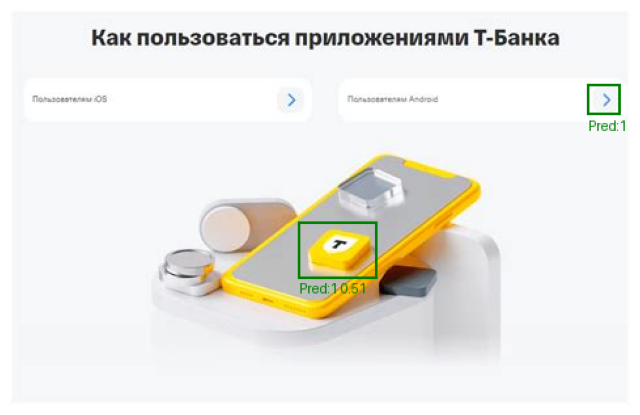

In [34]:
import os
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import torch
from torchvision import transforms as T
import torchvision


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
score_thr = 0.3  


transform = T.ToTensor()

images_dir = '/home/dmitriy/vs_code/T-bank/yolo_predict_val_train/images/train'
labels_dir = '/home/dmitriy/vs_code/T-bank/yolo_predict_val_train/labels/train'
dataset = YoloToDetDataset(images_dir, labels_dir, transforms=transform)


model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None, num_classes=2)  # background + logo
checkpoint = torch.load("/home/dmitriy/vs_code/T-bank/faster_best.pth", map_location=device)
model.load_state_dict(checkpoint["model_state"])
model.to(device)
model.eval()


def show_image_with_predictions(img, gt_boxes=None, gt_labels=None, score_thr=0.3):
    # img может быть PIL или Tensor
    orig_img = img.clone() if isinstance(img, torch.Tensor) else img
    if isinstance(img, torch.Tensor):
        img = T.ToPILImage()(img)

    draw = ImageDraw.Draw(img)


    if gt_boxes is not None and gt_labels is not None:
        for box, label in zip(gt_boxes, gt_labels):
            x1, y1, x2, y2 = box.tolist()
            draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
            draw.text((x1, y1-10), f"GT:{label.item()}", fill="red")


    with torch.no_grad():
        input_tensor = [orig_img.to(device)]
        outputs = model(input_tensor)[0]

    pred_boxes = outputs["boxes"].detach().cpu()
    pred_scores = outputs["scores"].detach().cpu()
    pred_labels = outputs["labels"].detach().cpu()

    for box, score, label in zip(pred_boxes, pred_scores, pred_labels):
        if score < score_thr:
            continue
        x1, y1, x2, y2 = box.tolist()
        draw.rectangle([x1, y1, x2, y2], outline="green", width=2)
        draw.text((x1, y2+2), f"Pred:{label.item()} {score:.2f}", fill="green")

    plt.figure(figsize=(8,8))
    plt.imshow(img)
    plt.axis('off')
    plt.show()


# for i in range(5):
#     img, target = dataset[i]
#     show_image_with_predictions(img, gt_boxes=target["boxes"], gt_labels=target["labels"], score_thr=score_thr)


def check_custom_image(image_path):
    img = Image.open(image_path).convert("RGB")
    tensor_img = transform(img)
    show_image_with_predictions(tensor_img, gt_boxes=None, gt_labels=None, score_thr=score_thr)


check_custom_image("/home/dmitriy/vs_code/T-bank/image copy.png")


In [9]:
import torch
print(torch.cuda.is_available())


True
